In [215]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import community
from networkx.algorithms import cluster
from networkx.generators import directed


import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.io import sql
import glob
#import sqlalchemy as sqa
from datetime import date
from glob import glob
from pathlib import Path


from scipy.optimize import curve_fit 
%matplotlib inline

In [2]:
file_path = Path('./data/nodes/nodes_countries.csv')
countries = pd.read_csv(file_path)

## Data upload

Uploading all pandas dfs

In [132]:
files = [ Path(path_str) for path_str in glob("data/edges/*") ]
times = list(map( lambda path:path.stem.strip('flights_'),files ))
dfs={
    time:pd.read_csv(path) for time,path in zip(times,files)
}

Create dictionary of all the graphs

In [92]:
graphs = {}
for time, df in dfs.items():
    G = nx.DiGraph()
    for index, row in df.iterrows():
        G.add_edge(row[0],row[1], weight=row[2])
    graphs[time] = G

    

In [99]:
graphs

{'2019_03': <networkx.classes.digraph.DiGraph at 0x7f51f3ebf190>,
 '2020_04': <networkx.classes.digraph.DiGraph at 0x7f51f51ef130>,
 '2019_02': <networkx.classes.digraph.DiGraph at 0x7f51f3a06d60>,
 '2020_02': <networkx.classes.digraph.DiGraph at 0x7f51f3ec4910>,
 '2020_01': <networkx.classes.digraph.DiGraph at 0x7f51f3a06d30>,
 '2021_01': <networkx.classes.digraph.DiGraph at 0x7f51f3a01760>,
 '2019_01': <networkx.classes.digraph.DiGraph at 0x7f5202cf1610>,
 '2020_03': <networkx.classes.digraph.DiGraph at 0x7f51f38676a0>,
 '2019_04': <networkx.classes.digraph.DiGraph at 0x7f51f39930d0>,
 '2021_02': <networkx.classes.digraph.DiGraph at 0x7f51f3ec6910>}

## Basic information: n of nodes and edges vs time

In [133]:
n_nodes =[]
n_edges = []
time_scale = []
for time in sorted(times):
    time_scale.append(time)
    n_nodes.append(graphs[time].number_of_nodes())
    n_edges.append(graphs[time].number_of_edges())

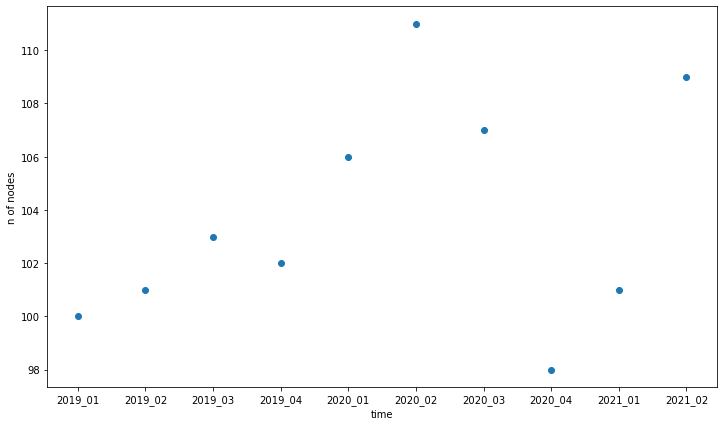

In [138]:
plt.figure(figsize=(12, 7)) 
plt.scatter(time_scale,n_nodes, label='n of nodes vs time')
plt.xlabel('time')
plt.ylabel('n of nodes')
plt.show()

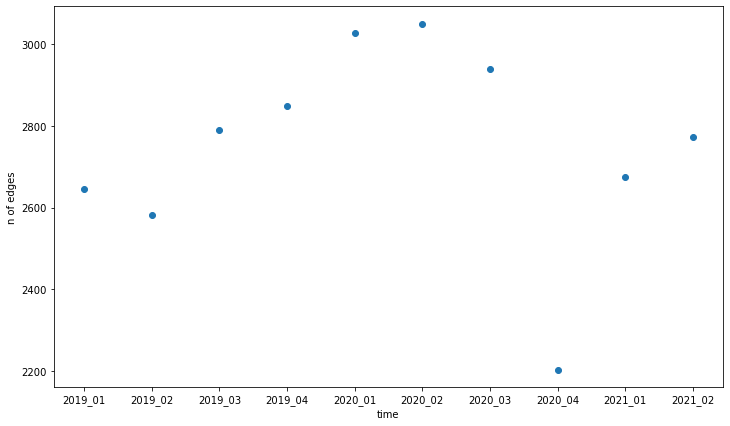

In [139]:
plt.figure(figsize=(12, 7)) 
plt.scatter(time_scale,n_edges, label='n of nodes vs time')
plt.xlabel('time')
plt.ylabel('n of edges')
plt.show()

## Degree, Average Degree and Degree Distribution - for directed graph

In [202]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Returns a list of the frequency of each degree value."""
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree(G.nodes(),'weight'))
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree(G.nodes(),'weight'))
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree(G.nodes(),'weight')]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq


In [273]:
def average_degree_directed(G):
    in_degree = dict(G.out_degree(G.nodes(),'weight'))
    degseq=[in_degree.get(k,0) for k in G.nodes()]
    d = sum(degseq)/len(degseq)
    return d

In [274]:
print(average_degree_directed(G))

7631.05504587156


In [209]:
def plot_degree_distribution(G):# TODO wrap it in one function 
    in_degree_freq = degree_histogram_directed(G, in_degree=True)
    out_degree_freq = degree_histogram_directed(G, out_degree=True)
    degrees = range(len(in_degree_freq))
    plt.figure(figsize=(8, 8)) 
    plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'b.', label='in-degree') 
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()
    
    plt.figure(figsize=(8, 8)) 
    plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'r.', label='out-degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

Networks are of the same nature thus their degree distribution is fairly similar  - no need to plot all of them.

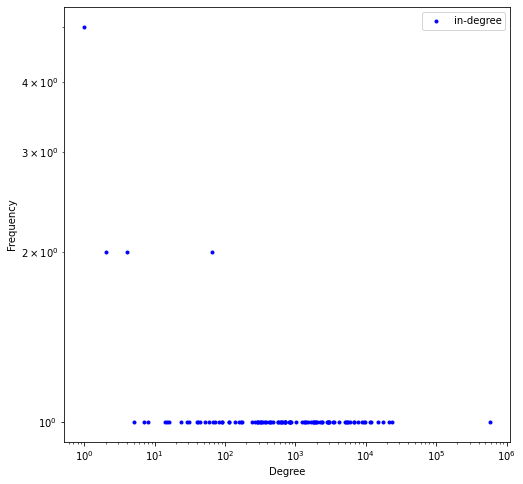

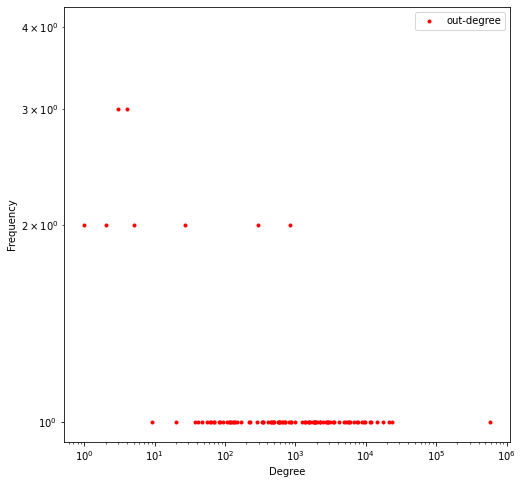

In [210]:
#for G in graphs.values():
    #plot_degree_distribution(G)
plot_degree_distribution(G)

## Plots on the whole network - not aggregated by country

## Basic plot

In [225]:
def plot_basic(G):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.axis("off")
    plt.show()

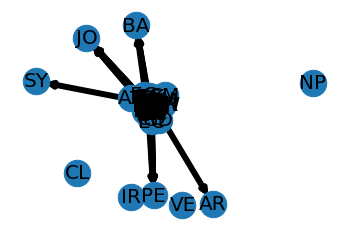

In [226]:
plot_basic(G)

## Identify nodes with zero out degree

There are some nodes with nonzero in-degree and zero out degree - identify - cross reference with corona db

In [ ]:
average_degree_directed(G)

In [172]:
def fit_func(x,a,mu):
    return np.sign(a)*(np.abs(a)*x)**mu

In [168]:
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Degree Distribution')
    
    plt.show()
    


def plot_knn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()
    
def plot_snn(G, fit=True): 
    snn_dict = nx.k_nearest_neighbors(G, weight='weight') 
    k_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(snn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor strength')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()
    
    
    
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    
    plt.show()

In [41]:
def print_attributes_and_plots(G):
    print (nx.info(G))
    if not nx.is_directed(G):
        if nx.is_connected(G):
            print ('Diameter: %s' % nx.diameter(G)) # print diameter of the network
        else:
            print ('Graph not connected: infinite path length')
            print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))
    print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))
    plot_degree_dist(G)
    plot_knn(G, fit=False)
    if not nx.is_directed(G):
        plot_clustering_coefficient(G)

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 2645
Average in degree:  26.4500
Average out degree:  26.4500
Degree Assortativity Coefficient (r): -0.1948474211462744


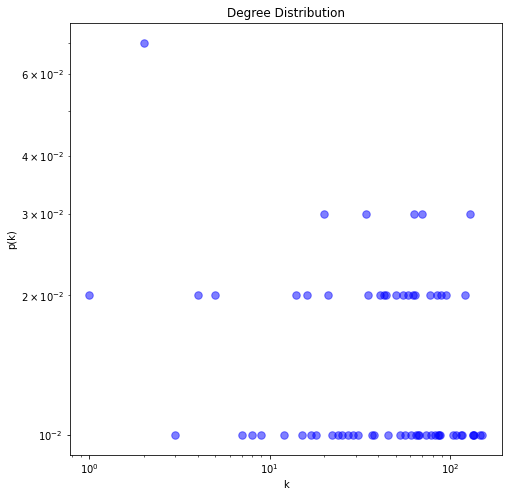

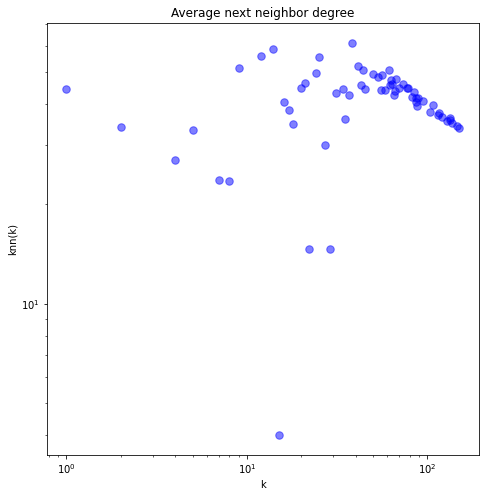

In [42]:
print_attributes_and_plots(G)

In [55]:
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
comm_sets = sorted(map(sorted, next_level_communities))

## Centrality ranking

In [149]:
in_deg_centrality = nx.in_degree_centrality(G)
out_deg_centrality = nx.out_degree_centrality(G)

## Clustering 


### Comparison to random network

In [164]:
#TODO build a random network

In [165]:
# plot it's characteristics in order to compare with our network

In [234]:
G2 = nx.DiGraph(random_G)

In [247]:
random_G[0].values()

ValuesView(AdjacencyView({25: {0: {}}, 69: {0: {}}, 87: {0: {}}, 26: {0: {}, 1: {}}, 57: {0: {}, 1: {}}, 33: {0: {}}, 89: {0: {}}, 36: {0: {}}, 35: {0: {}}, 83: {0: {}}, 74: {0: {}}, 84: {0: {}}, 59: {0: {}}, 40: {0: {}}, 53: {0: {}}, 98: {0: {}}, 14: {0: {}}, 86: {0: {}}, 95: {0: {}}, 12: {0: {}}, 2: {0: {}}, 99: {0: {}}, 50: {0: {}}}))

### ‫‪clustering‬‬ ‫‪coefficient,‬‬ ‫‪clustering‬‬ ‫‪coefficient‬‬ ‫‪of‬‬ ‫‪random‬‬ ‫‪network‬‬‬

In [159]:
nx.average_clustering(G)

0.6880894349379032

In [223]:
nx.average_clustering(G2)

0.2802271590967772

Create random network preserving weights and in and out degree

In [160]:
nx.degree_assortativity_coefficient(G)

-0.16750164066927067

## ‫‪Degree‬‬ ‫‪correlation(Knn‬‬ ‫‪vs‬‬ ‫‪k),‬‬ ‫‪Hierarchy (C(k) vs k)

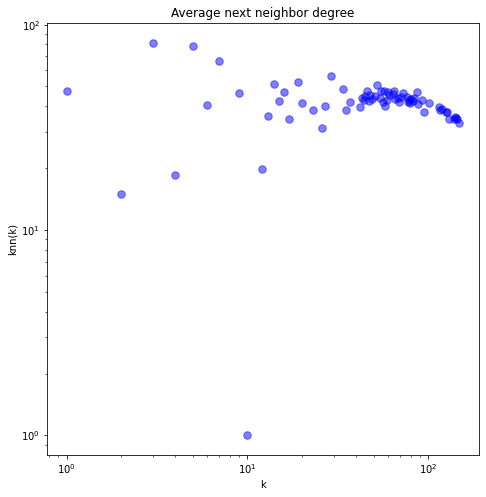

In [175]:
plot_knn(G,fit = False)

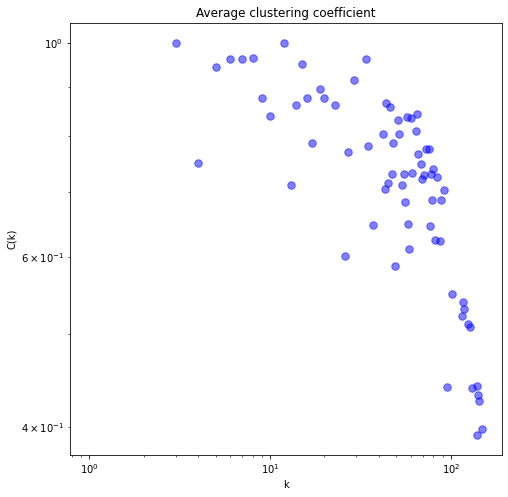

In [166]:
 plot_clustering_coefficient(G)

## Comunity detection